In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import os

In [27]:
# Load Data
print("Working directory:", os.getcwd())

data_dir = "../data/raw/"
bridges_path = os.path.join(data_dir, "BMMS_overview.xlsx")
roads_path = os.path.join(data_dir, "_roads3.csv")

Working directory: C:\Users\audiv\PycharmProjects\AdvancedSimulation\EPA133a-G04-A3\data


In [28]:
# Read data
bridges = pd.read_excel(bridges_path)
roads = pd.read_csv(roads_path)

In [29]:
# Convert roads to a GeoDataFrame
roads['geometry'] = roads.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_roads = gpd.GeoDataFrame(roads, geometry='geometry', crs="EPSG:4326")

In [30]:
# Filter only data for N1, N2, and side roads (N1xx, N2xx)
gdf_roads = gdf_roads[gdf_roads['road'].str.match(r'^(N1|N2)\d*$', na=False)]
bridges = bridges[bridges['road'].str.match(r'^(N1|N2)\d*$', na=False)]

In [31]:
# Create road lines
gdf_roads_sorted = gdf_roads.sort_values(by=['road', 'chainage'])
road_lines = gdf_roads_sorted.groupby('road')['geometry'].apply(lambda x: LineString(x.tolist()) if len(x) > 1 else None).dropna()
road_lines = gpd.GeoDataFrame(road_lines, columns=['geometry'], crs="EPSG:4326")

In [32]:
# Detect intersections between roads
line_dict = {road: line for road, line in zip(road_lines.index, road_lines.geometry)}
intersections = []
for road1, line1 in line_dict.items():
    for road2, line2 in line_dict.items():
        if road1 != road2 and line1.intersects(line2):
            intersection_points = line1.intersection(line2)
            if intersection_points.geom_type == "Point":
                intersections.append((road1, road2, intersection_points))
            elif intersection_points.geom_type == "MultiPoint":
                for point in intersection_points.geoms:
                    intersections.append((road1, road2, point))

In [33]:
# Convert intersections to a GeoDataFrame
intersection_df = pd.DataFrame(intersections, columns=["road1", "road2", "geometry"])
intersection_gdf = gpd.GeoDataFrame(intersection_df, geometry='geometry', crs="EPSG:4326")

In [34]:
# Find nearest existing road points for each intersection
def find_nearest_road_point(intersection, gdf_roads):
    min_dist = float("inf")
    nearest_idx = None
    for idx, row in gdf_roads.iterrows():
        dist = intersection.distance(row.geometry)
        if dist < min_dist:
            min_dist = dist
            nearest_idx = idx
    return nearest_idx

In [35]:

intersection_gdf['nearest_idx'] = intersection_gdf['geometry'].apply(lambda x: find_nearest_road_point(x, gdf_roads))


In [36]:
# Assign 'intersection' model_type to nearest points
gdf_roads.loc[intersection_gdf['nearest_idx'], 'model_type'] = 'intersection'
gdf_roads['is_intersection'] = gdf_roads['model_type'] == 'intersection'

In [37]:
# Save the filtered roads and bridges for further processing
data_direct = "../data/"
gdf_roads.to_csv(os.path.join(data_direct, "roads_test_filtered.csv"), index=False)
bridges.to_csv(os.path.join(data_direct, "bridges_test_filtered.csv"), index=False)

In [38]:
# Assuming you've already saved your filtered data:
roads = pd.read_csv("../data/roads_test_filtered.csv")    # e.g. columns: [road, chainage, lat, lon, type, name, is_intersection, ...]
bridges = pd.read_csv("../data/bridges_test_filtered.csv") # e.g. columns: [road, km (chainage), lat, lon, type, name, condition, length, ...]

In [39]:
# 2.1 Rename chainage column if needed
# roads may already have a 'chainage' column, so no change is required.
# If your chainage column is named differently (e.g. "km"), rename it:
# roads.rename(columns={'km': 'chainage'}, inplace=True)

# 2.2 Create a new DataFrame with the columns you need
roads_df = pd.DataFrame()
roads_df['road'] = roads['road']
roads_df['chainage'] = roads['chainage']
roads_df['lat'] = roads['lat']
roads_df['lon'] = roads['lon']
roads_df['name'] = roads['name']

# We'll set 'condition' to NaN for roads (since it usually applies to bridges)
roads_df['condition'] = np.nan

# We'll leave 'length' at 0 or NaN for now—unless you have a specific way
# to calculate length for road segments:
roads_df['length'] = 0

# 2.3 Determine model_type for roads
#    - If is_intersection == True, then 'intersection'
#    - Otherwise, default to 'link'
roads_df['model_type'] = np.where(
    roads['is_intersection'] == True,
    'intersection',
    'link'
)


In [40]:
bridges_df = pd.DataFrame()
bridges_df['road'] = bridges['road']

# If your bridges have a column called 'km' for chainage, rename it:
# bridges.rename(columns={'km': 'chainage'}, inplace=True)
bridges_df['chainage'] = bridges['chainage']  # or 'chainage' if already named that

bridges_df['lat'] = bridges['lat']
bridges_df['lon'] = bridges['lon']
bridges_df['name'] = bridges['name']
bridges_df['condition'] = bridges['condition']
bridges_df['length'] = bridges['length']  # from the bridges data
bridges_df['model_type'] = 'bridge'


In [41]:
df_combined = pd.concat([roads_df, bridges_df], ignore_index=True)


In [42]:
def label_sourcesink(group):
    min_chain = group['chainage'].min()
    max_chain = group['chainage'].max()

    # Mark rows that match min or max chainage
    mask_min = (group['chainage'] == min_chain)
    mask_max = (group['chainage'] == max_chain)

    group.loc[mask_min, 'model_type'] = 'sourcesink'
    group.loc[mask_max, 'model_type'] = 'sourcesink'

    return group

df_combined = df_combined.groupby('road', group_keys=False).apply(label_sourcesink)


In [43]:
df_combined = df_combined.sort_values(by=['road', 'chainage']).reset_index(drop=True)


In [44]:
start_id = 1000000
df_combined['id'] = range(start_id, start_id + len(df_combined))


In [45]:
# 2. For each road, shift the chainage and compute the difference
df_combined['prev_chainage'] = df_combined.groupby('road')['chainage'].shift(1)

# 3. Calculate segment length as chainage - prev_chainage
df_combined['length'] = df_combined['chainage'] - df_combined['prev_chainage']

# 4. For the first row of each road (where prev_chainage is NaN), fill with 0
df_combined['length'] = df_combined['length'].fillna(0)

# 5. Drop the helper column if you like
df_combined.drop(columns=['prev_chainage'], inplace=True)

# Now df_combined['length'] contains the segment length in the same unit as chainage.

In [46]:
df_combined = df_combined[[
    'road',
    'id',
    'model_type',
    'condition',
    'name',
    'lat',
    'lon',
    'length'
]]

In [47]:
display(df_combined.head(40))
df_combined.to_csv("../data/test_n1_n2.csv", index=False)


,road,id,model_type,condition,name,lat,lon,length
0,N1,1000000,sourcesink,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000
1,N1,1000001,link,NaN,Box Culvert,23.702917,90.450417,0.814
2,N1,1000002,link,NaN,Intersection with Z1101,23.702778,90.450472,0.008
3,N1,1000003,link,NaN,Km post missing,23.702139,90.451972,0.178
4,N1,1000004,bridge,A,.,23.698739,90.458861,0.800
5,N1,1000005,link,NaN,Km post missing,23.697889,90.460583,0.200
6,N1,1000006,link,NaN,Box culvert,23.697361,90.461667,0.130
7,N1,1000007,link,NaN,Km post missing,23.693833,90.469138,0.870
8,N1,1000008,link,NaN,Km post missing,23.693611,90.478777,1.000
9,N1,1000009,link,NaN,Road to Narayanganj(R111),23.693805,90.480527,0.175


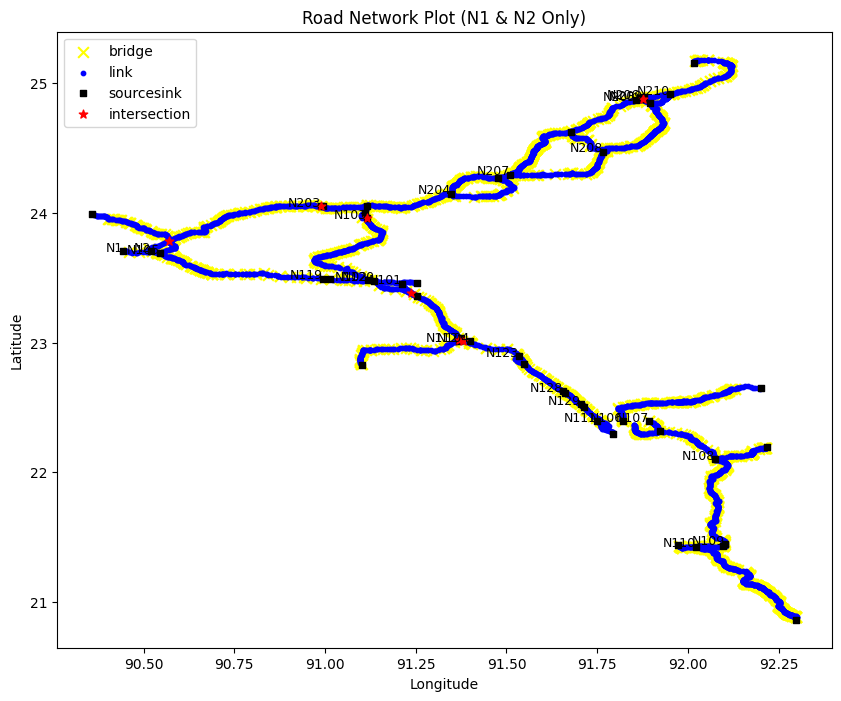

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df_combined = pd.read_csv("../data/test_n1_n2.csv")

colors = {
    'bridge': 'yellow',
    'link': 'blue',
    'sourcesink': 'black',
    'intersection': 'red'
}

markers = {
    'bridge': 'x',
    'link': 'o',
    'sourcesink': 's',
    'intersection': '*'
}

marker_sizes = {
    'bridge': 60,
    'link': 10,
    'sourcesink': 20,
    'intersection': 40
}

plt.figure(figsize=(10, 8))

for model_type, color in colors.items():
    subset = df_combined[df_combined['model_type'] == model_type]
    plt.scatter(subset['lon'], subset['lat'], c=color, label=model_type, s=marker_sizes[model_type],
                marker=markers[model_type])

for road in df_combined['road'].unique():
    first_point = df_combined[df_combined['road'] == road].iloc[0]
    plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network Plot (N1 & N2 Only)')
plt.legend()
plt.show()

In [49]:
print(f"Total intersections found: {len(intersection_gdf)}")


Total intersections found: 26


In [50]:
num_intersections = gdf_roads[gdf_roads['is_intersection']].shape[0]
print(f"Number of road points classified as intersections: {num_intersections}")


Number of road points classified as intersections: 13
